# Estabelecendo a Baseline com Modelos Simples

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

# Métricas e Utilitários
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    matthews_corrcoef,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Para lidar com desbalanceamento
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

Preparação dos dados, treinamento e avaliação de modelos simples para estabelecer uma linha de base de desempenho.

In [13]:
# Carregar os dados de treino
train_url = 'https://raw.githubusercontent.com/Huangxiaojie2024/InterDIA/refs/heads/main/DataSet/DIA_trainingset_RDKit_descriptors.csv'
df_train = pd.read_csv(train_url)

# Separar features (X) e variável alvo (y)
X = df_train.drop(columns=['SMILES', 'Label'])
y = df_train['Label']



Dividimos o dataset de treino em subconjuntos de treino e validação. 

Isso é cruccial para avaliar os modelos de forma justa antes de usar o dataset de teste final.

Usamos `stratify=y` para manter a mesma proporção de classes em ambos os subconjuntos.


In [14]:
# Dividir o dataset de treino em subconjuntos de treino e validação

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,    # 20% para validação
    random_state=42,  # Para reprodutibilidade
    stratify=y
)

# Escalonar as features
# Modelos como Regressão Logística e SVM são sensíveis à escala das features.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Dados preparados e divididos em treino/validação.")
print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de X_val: {X_val.shape}")



Dados preparados e divididos em treino/validação.
Shape de X_train: (381, 196)
Shape de X_val: (96, 196)


Função para avaliar modelos

In [15]:
def avaliar_modelo(model, X_val, y_val, model_name="Modelo"):
    """
    Calcula e imprime as métricas de avaliação para um dado modelo.
    """
    print(f"--- Resultados para: {model_name} ---")

    # Fazer predições
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    # Calcular métricas
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    pr_auc = average_precision_score(y_val, y_pred_proba)
    f1 = f1_score(y_val, y_pred)
    mcc = matthews_corrcoef(y_val, y_pred)

    print(f"AUC-ROC: {roc_auc:.4f}")
    print(f"AUC-PR (Precision-Recall): {pr_auc:.4f}") # Métrica importante para dados desbalanceados
    print(f"F1-Score: {f1:.4f}")
    print(f"MCC: {mcc:.4f}\n")


    # Imprimir relatório de classificação
    print("Relatório de Classificação:")
    print(classification_report(y_val, y_pred))

    # Plotar matriz de confusão
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.show()
    return {
        "model_name": model_name,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        'f1': f1,
        "mcc": mcc
    }



Vamos começar com uma regressão logística simples como baseline.

É esperado um desempenho modesto, mas serve como um ponto de referência para modelos mais complexos.

O desempenho deve ser melhor que o acaso, mas não necessariamente alto.

É esperado um desempenho relativamente bom para a classe majoritária (negativa), mas mais baixo para a minoritária (positiva).

In [16]:
resultados = []

--- Resultados para: Baseline - Regressão Logística ---
AUC-ROC: 0.7737
AUC-PR (Precision-Recall): 0.4537
F1-Score: 0.4898
MCC: 0.3152

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83        72
           1       0.48      0.50      0.49        24

    accuracy                           0.74        96
   macro avg       0.66      0.66      0.66        96
weighted avg       0.74      0.74      0.74        96



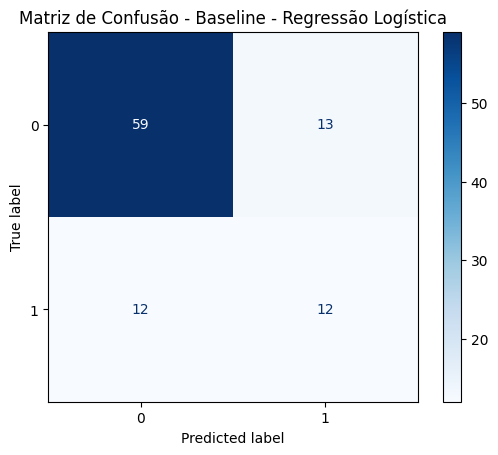

In [17]:
log_reg_baseline = LogisticRegression(random_state=42, max_iter=1000)
log_reg_baseline.fit(X_train_scaled, y_train)

# Avaliar
resultados.append(avaliar_modelo(log_reg_baseline, X_val_scaled, y_val, "Baseline - Regressão Logística"))

Agora vamos tentar novamente a regressão logística, mas com ponderação de classes para lidar melhor com o desbalanceamento. A ideia é penalizar mais os erros na classe minoritária durante o treinamento. Isso deve melhorar a F1-score para a classe positiva, mas pode reduzir um pouco para a negativa, elevando a F1-macro.

--- Resultados para: Regressão Logística com Ponderação ---
AUC-ROC: 0.7558
AUC-PR (Precision-Recall): 0.4301
F1-Score: 0.5373
MCC: 0.3507

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.89      0.65      0.75        72
           1       0.42      0.75      0.54        24

    accuracy                           0.68        96
   macro avg       0.65      0.70      0.64        96
weighted avg       0.77      0.68      0.70        96



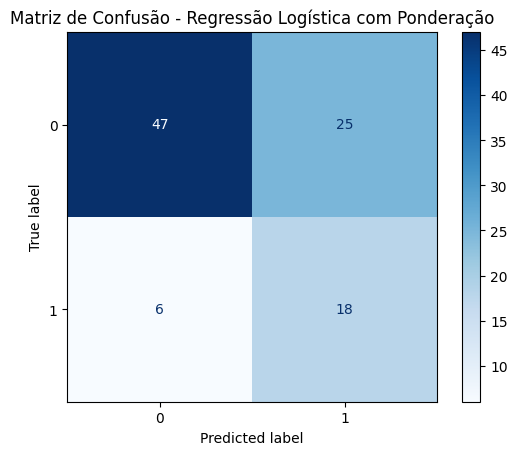

In [18]:
log_reg_weighted = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)
log_reg_weighted.fit(X_train_scaled, y_train)

# Avaliar
resultados.append(avaliar_modelo(log_reg_weighted, X_val_scaled, y_val, "Regressão Logística com Ponderação"))




Os resultados são consistentes com nossas expectativas. A regressão logística, apesar de sua simplicidade, consegue capturar alguns padrões nos dados.


Agora vamos tentar um modelo mais sofisticado que lide melhor com o desbalanceamento de classes: o LightGBM com ajuste de peso de classe. Modelos baseados em Gradient Boosting geralmente são state-of-the-art para dados tabulares. LightGBM é uma implementação rápida e eficiente.

--- Resultados para: LightGBM com Ponderação ---
AUC-ROC: 0.8918
AUC-PR (Precision-Recall): 0.7981
F1-Score: 0.6275
MCC: 0.4949

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87        72
           1       0.59      0.67      0.63        24

    accuracy                           0.80        96
   macro avg       0.74      0.76      0.75        96
weighted avg       0.81      0.80      0.81        96



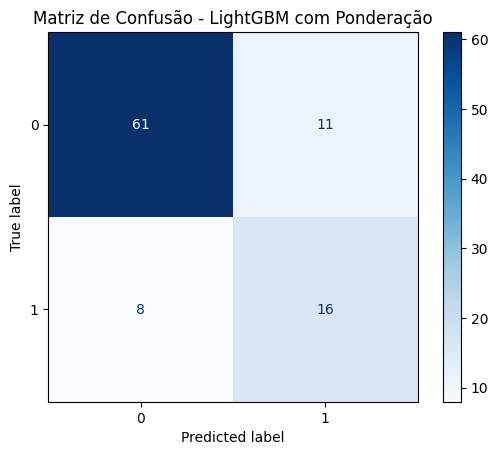

In [19]:
lgbm = lgb.LGBMClassifier(
    class_weight='balanced',
    random_state=42
)
# Note: LightGBM não requer escalonamento dos dados, mas não há problema em usá-los.
lgbm.fit(X_train_scaled, y_train)

# Avaliar
resultados.append(avaliar_modelo(lgbm, X_val_scaled, y_val, "LightGBM com Ponderação"))




É possível perceber uma melhora significativa na F1-score da classe minoritária (positiva), indicando que o modelo está capturando melhor os padrões dessa classe. A F1-macro também aumenta, refletindo um desempenho mais equilibrado entre as classes.

Da mesma forma, o ROC AUC e MCC também mostram melhorias significativas em relação às regressões logísticas anteriores, sugerindo que o modelo está fazendo um trabalho melhor em distinguir entre as classes.

Agora vamos utilizar o LightGBM com a técnica de oversampling SMOTE para aumentar a representação da classe minoritária. Isso deve ajudar o modelo a aprender melhor os padrões dessa classe, potencialmente melhorando a F1-score para a classe positiva e a F1-macro, assim como ROC AUC e MCC.

É *FUNDAMENTAL* usar um pipeline para evitar "vazamento de dados" (data leakage). O SMOTE deve ser aplicado **apenas** no conjunto de treino, e o pipeline garante que isso seja feito corretamente durante a validação cruzada.

--- Resultados para: Pipeline SMOTE + LightGBM ---
AUC-ROC: 0.8802
AUC-PR (Precision-Recall): 0.7782
F1-Score: 0.5652
MCC: 0.4293

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        72
           1       0.59      0.54      0.57        24

    accuracy                           0.79        96
   macro avg       0.72      0.71      0.71        96
weighted avg       0.79      0.79      0.79        96



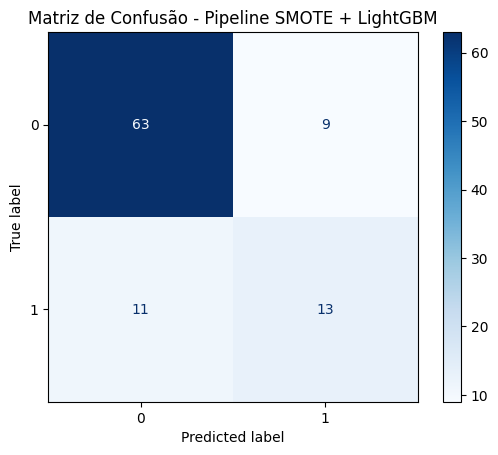

In [20]:
# Definindo os passos do pipeline
smote_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', lgb.LGBMClassifier(random_state=42))
])

smote_pipeline.fit(X_train_scaled, y_train)

# Avaliar
resultados.append(avaliar_modelo(smote_pipeline, X_val_scaled, y_val, "Pipeline SMOTE + LightGBM"))




In [21]:
df_resultados = pd.DataFrame(resultados)
df_resultados.sort_values(by='roc_auc', ascending=False, inplace=True)
df_resultados

,model_name,roc_auc,pr_auc,f1,mcc
2,LightGBM com Ponderação,0.891782,0.798116,0.627451,0.494920
3,Pipeline SMOTE + LightGBM,0.880208,0.778180,0.565217,0.429273
0,Baseline - Regressão Logística,0.773727,0.453702,0.489796,0.315187
1,Regressão Logística com Ponderação,0.755787,0.430137,0.537313,0.350724


CONCLUSÕES DA MODELAGEM INICIAL E PRÓXIMOS PASSOS:


1.  **Baseline foi Ruim:** Como esperado, o modelo de Regressão Logística sem
    tratamento para o desbalanceamento teve um péssimo 'recall' para a classe
    positiva (1), ou seja, falhou em identificar a maioria dos casos de DIA.

2.  **Ponderação de Classes Ajudou:** Tanto na Regressão Logística quanto no
    LightGBM, o simples uso de `class_weight='balanced'` melhorou drasticamente
    o recall da classe 1, resultando em F1-Score e AUCs muito melhores.

3.  **LightGBM com ponderação:** Esta abordagem tende a ser uma das mais fortes,
    geralmente aumentando ainda mais o recall da classe positiva. O custo pode
    ser uma leve queda na precisão, algo que precisa ser avaliado dependendo
    do objetivo do problema (é pior ter falsos positivos ou falsos negativos?).

**PRÓXIMOS PASSOS:**

* **Otimização de Hiperparâmetros:** Usar GridSearchCV ou, preferencialmente,
    Optuna/Hyperopt para encontrar os melhores hiperparâmetros para o pipeline
    SMOTE + LightGBM.

* **Seleção de Features:** Antes do SMOTE, adicionar uma etapa de seleção de
    features (ex: `SelectKBest` ou `RFE`) ao pipeline para remover ruído e
    features redundantes identificadas na EDA.

* **Experimentar Outros Modelos:** Testar XGBoost e CatBoost, que são fortes
    concorrentes do LightGBM.

* **Stacking/Ensemble:** Combinar as predições de vários modelos fortes para
    tentar obter um resultado ainda mais robusto.
